@author: Amaury Lancelin  

This notebook contains the code to reproduce the interpretability plots for ScatNet.

In [1]:
import os 
import sys
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import seaborn as sns
import importlib as imp
import pandas as pd
import scipy.ndimage
import seaborn as sns
sns.set_theme()

# ScatNet: Localise features in spatial and frequency domain

In [2]:
path_to_data_plots = os.getcwd()

# path to feature importance maps for scatnet for 5 folds
fi_maps_wave = np.load(path_to_data_plots + "/ScatNet/scatnet_fi_mu_maps_wave_5fold.npy")
fi_maps_coarse = np.load(path_to_data_plots + "/ScatNet/scatnet_fi_mu_maps_coarse_5fold.npy")
fi_maps_sm = np.load(path_to_data_plots + "/ScatNet/scatnet_fi_mu_maps_sm_5fold.npy")
percentage_fi = pd.read_csv(path_to_data_plots + "/ScatNet/scatnet_mu_percentage_fi_5fold.csv")


# load GA pattern and predictions on test set for fold 0

map_p = np.load(path_to_data_plots+ "/GA/r800y/0/fold_0/proj.npy")*np.load(path_to_data_plots+'/GA/r800y/0/fold_0/msigma.npy')[0]
mu_ga = np.load(path_to_data_plots + "/GA/r800y/0/fold_0/Y_pred_te.npy")[:,0]
# print(mu_ga[indices], A_test[indices], preds_ga)

# load lat, lon
lat = np.load(path_to_data_plots + "/common/lat.npy")
lon = np.load(path_to_data_plots + "/common/lon.npy")

#### Check scores obtained by the ScatNet

In [3]:
path_test = os.getcwd() + "/ScatNet/scatnet_test_2024-04-19_11-48.csv"
scores_test = pd.read_csv(path_test).rename(columns={"Unnamed: 0": "Fold"}).set_index("Fold")
scores_test, scores_test.mean(), scores_test.std()

(           crpss      nlls      bces
 Fold                                
 fold_0  0.309966  0.244642  0.322922
 fold_1  0.309051  0.242339  0.312928
 fold_2  0.309698  0.247764  0.314540
 fold_3  0.310884  0.250601  0.315107
 fold_4  0.309071  0.243835  0.306617,
 crpss    0.309734
 nlls     0.245836
 bces     0.314423
 dtype: float64,
 crpss    0.000756
 nlls     0.003320
 bces     0.005828
 dtype: float64)

#### GA vs Scatnet Coarse image (Fig. 5 Article)

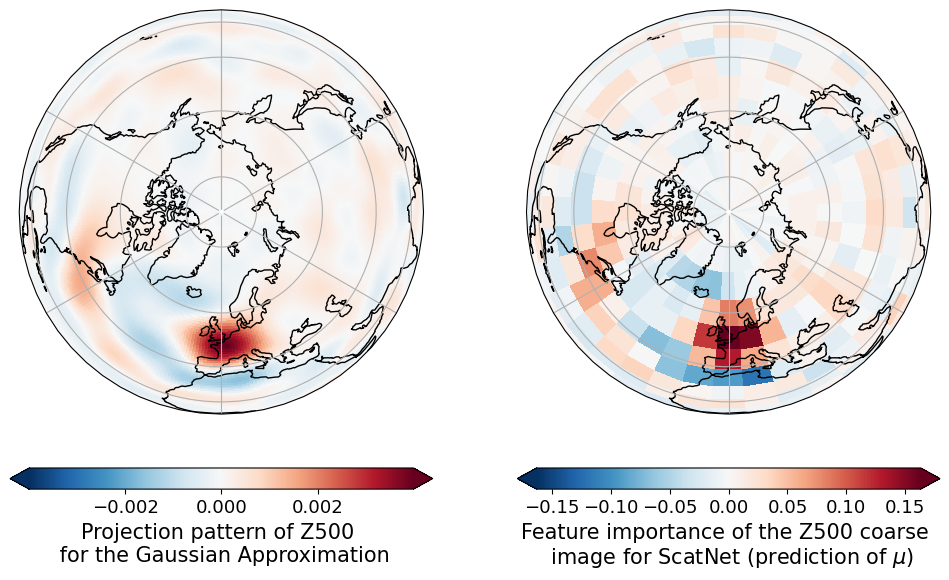

In [4]:
# default matplotlib params
plt.rcParams.update(plt.rcParamsDefault)
# coarse-grain the lat and lon up to 2^3 pixels
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

n_col= 2
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(1, n_col, subplot_kw={'projection': projection}, figsize=(12*1., 7*1.))
font_tick = 13
font_size_colorbar = 15
pad_colorbar = 0.03
font_size_title = 15
fraction_colorbar = 0.15


ax = axs[0]
idx_channel = 0
map_data = map_p[:,:,0] 
img = ax.pcolormesh(lon, lat, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
scale = 1.
img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=fraction_colorbar, pad=0.1, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
cbar.set_label(f'Projection pattern of Z500 \n for the Gaussian Approximation', fontsize=font_size_colorbar)


ax = axs[1]
map_data = np.mean(fi_maps_coarse, axis=-1)[:,:]
# map_data = ScatNet.scat_representation(np.expand_dims(weights_mu, axis=0))[0][0][:,:,0]
img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
scale = 1.
img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=fraction_colorbar, pad=0.1, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
cbar.set_label("Feature importance of the Z500 coarse \n image " +  fr"for ScatNet (prediction of $\mu$)", fontsize=font_size_colorbar)
plt.show()

#### Comparaison Feature importance for each folds for (theta, j) = (0,2)

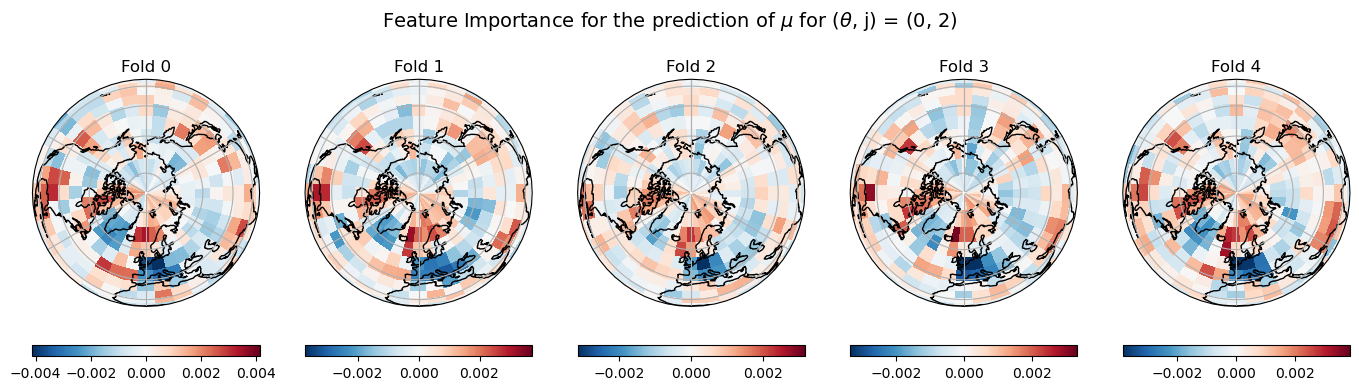

In [5]:
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

# plot a pannel with all importance maps for the 24 last channels
n_orient = 8
n_scale = 3
j = 2
thet = 0

projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(1, 5, subplot_kw={'projection': projection}, figsize=(17, 5)) 
for fold in range(5):

    idx_channel = 1 + thet + j*n_orient
    # print(idx_channel)
    ax = axs[fold]
    map_data = fi_maps_wave[:,:,j, thet, fold]
    # map_data = fi_maps_coarse[:,:,fold]
    img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    scale = 0.00028
    # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
    total_importance = percentage_fi['total_imp'][fold]
    # scale = 1
    # total_importance = np.abs(map_data).max()
    img.set_clim(vmin=-scale*total_importance , vmax=scale*total_importance )
    # total_importance 
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    # Add colorbar
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
    ax.set_title(fr'Fold {fold}')
    # suptitle with a pad of 20
    plt.suptitle(fr'Feature Importance for the prediction of $\mu$ for ($\theta$, j) = ({thet}, {j})', fontsize=14, y=0.82)

plt.show()

#### Mean feature importance (across folds) for each theta, and j=2.

In [6]:
def plot_azimuth(ax, azimuth):
    if (azimuth + 90) % 180 == 0:
        lats = np.linspace(90,0,6)
        _lon = np.linspace(0,360,1000)
        for _lat in lats[1:]:
            ax.plot(_lon, _lat*np.ones_like(_lon), color='black', transform=ccrs.PlateCarree())

    else:
        s = 130*np.sin(azimuth*np.pi/180) + 1
        n = min(max(int(360/s), 1),8)
        if n==3:
            n = 4
        for i in range(n):
            _lat = np.linspace(90, 0, 1000)
            _lon = _lat*np.tan(azimuth*np.pi/180) + i/n * 360

            ax.plot(_lon, _lat, color='black', transform=ccrs.PlateCarree())

# define a discretization of the angles 
angle_step = 180/8
discr_L = np.array([(i-3)*angle_step for i in range(8)])
# if it's negative, we add 180 to it
discr_L[discr_L < 0] += 180
print(discr_L)

[112.5 135.  157.5   0.   22.5  45.   67.5  90. ]


In [7]:
percentage_fi['total_imp']

0    14.713132
1    13.323651
2    11.306213
3    11.934780
4    13.731919
Name: total_imp, dtype: float64

#### Mean Feature Importance for each $\theta$ and $j=2$ for the prediction of mu (Fig. 6 Article)

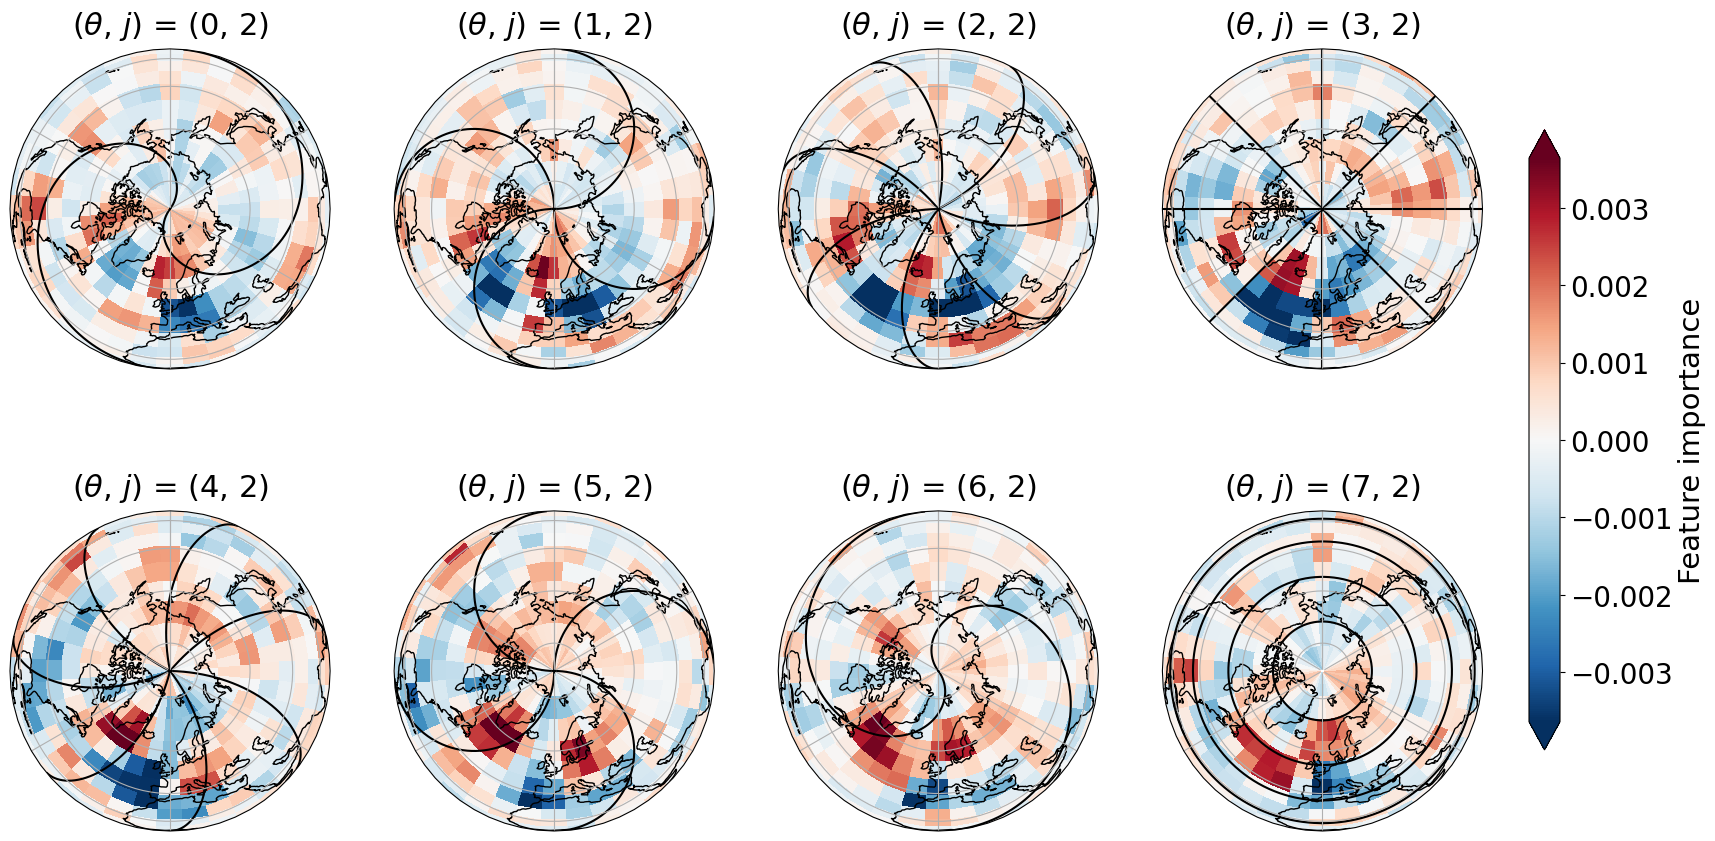

In [8]:
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

# plot a pannel with all importance maps for the 24 last channels
n_orient = 8
n_scale = 3
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': projection}, figsize=(20, 11))
font_tick = 20
font_size_colorbar = 21
pad_colorbar = 0.03
font_size_title = 22
fraction_colorbar = 0.02

for thet in range(n_orient):
    for j in reversed(range(n_scale)):
        if j == 2:
            idx_channel = 1 + thet + j*n_orient
            # print(idx_channel)
            ax = axs[thet//4, thet%4]
            # map_data = feature_importance_weights[:,:,idx_channel]
            map_data = np.mean(fi_maps_wave[:,:,j, thet, :], axis=-1) # the sign is obtain from the weights of the linear model
            img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
            # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
            total_importance = percentage_fi['total_imp'].mean()
            img.set_clim(vmin=-scale*total_importance , vmax=scale*total_importance )
            # total_importance 
            # Add coastlines and gridlines
            ax.coastlines()
            ax.gridlines()
            # Add colorbar
            if thet == 3: 
                cbar = plt.colorbar(img, ax=axs[:, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
                cbar.set_label(fr'Feature importance', fontsize=font_size_colorbar)
                cbar.ax.tick_params(labelsize=font_tick)
            ax.set_title(fr'($\theta$, $j$) = ({thet}, {j})', fontsize=font_size_title, y=1.02)
            plot_azimuth(ax, discr_L[thet])
# suptitle with a pad of 20
# plt.suptitle(r'Mean Feature Importance for the prediction of $\mu$', fontsize=16, y=0.98)
plt.show()

#### Mean feature importance (across folds) for each j and theta=0.

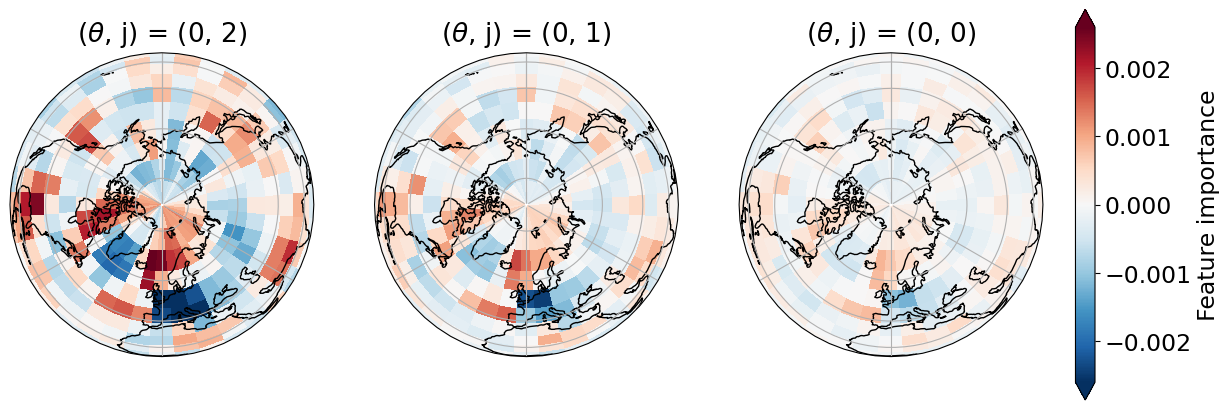

In [9]:
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

# plot a pannel with all importance maps for the 24 last channels
n_orient = 8
n_scale = 3
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(n_orient-7, n_scale, subplot_kw={'projection': projection}, figsize=(14, 7))
font_size_colorbar = 17
pad_colorbar = 0.03
font_size_title = 19
fraction_colorbar = 0.018
font_tick = 17

for thet in range(n_orient-7):
    for j in reversed(range(n_scale)):
        idx_channel = 1 + thet + j*n_orient
        # print(idx_channel)
        ax = axs[2-j]
        map_data = np.mean(fi_maps_wave[:,:,j, thet, :], axis=-1)
        img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
        scale = 0.00020
        # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
        mean_total_importance = np.mean(percentage_fi['total_imp'])
        img.set_clim(vmin=-scale*total_importance , vmax=scale*total_importance )
        # total_importance 
        # Add coastlines and gridlines
        ax.coastlines()
        ax.gridlines()
        if thet==0 and j == 0:
            cbar = plt.colorbar(img, ax=axs[:], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
            cbar.ax.tick_params(labelsize=font_tick)
            cbar.set_label('Feature importance', fontsize=font_size_colorbar)
        ax.set_title(fr'($\theta$, j) = ({thet}, {j})', fontsize=font_size_title, y=1.01)
# suptitle with a pad of 20
# plt.suptitle(r'Mean Feature Importance maps for the prediction of $\mu$ across each folds', fontsize=16, y=0.91)
plt.show()

#### Mean and std Feature Importance maps for the prediction of $\mu$ across each folds

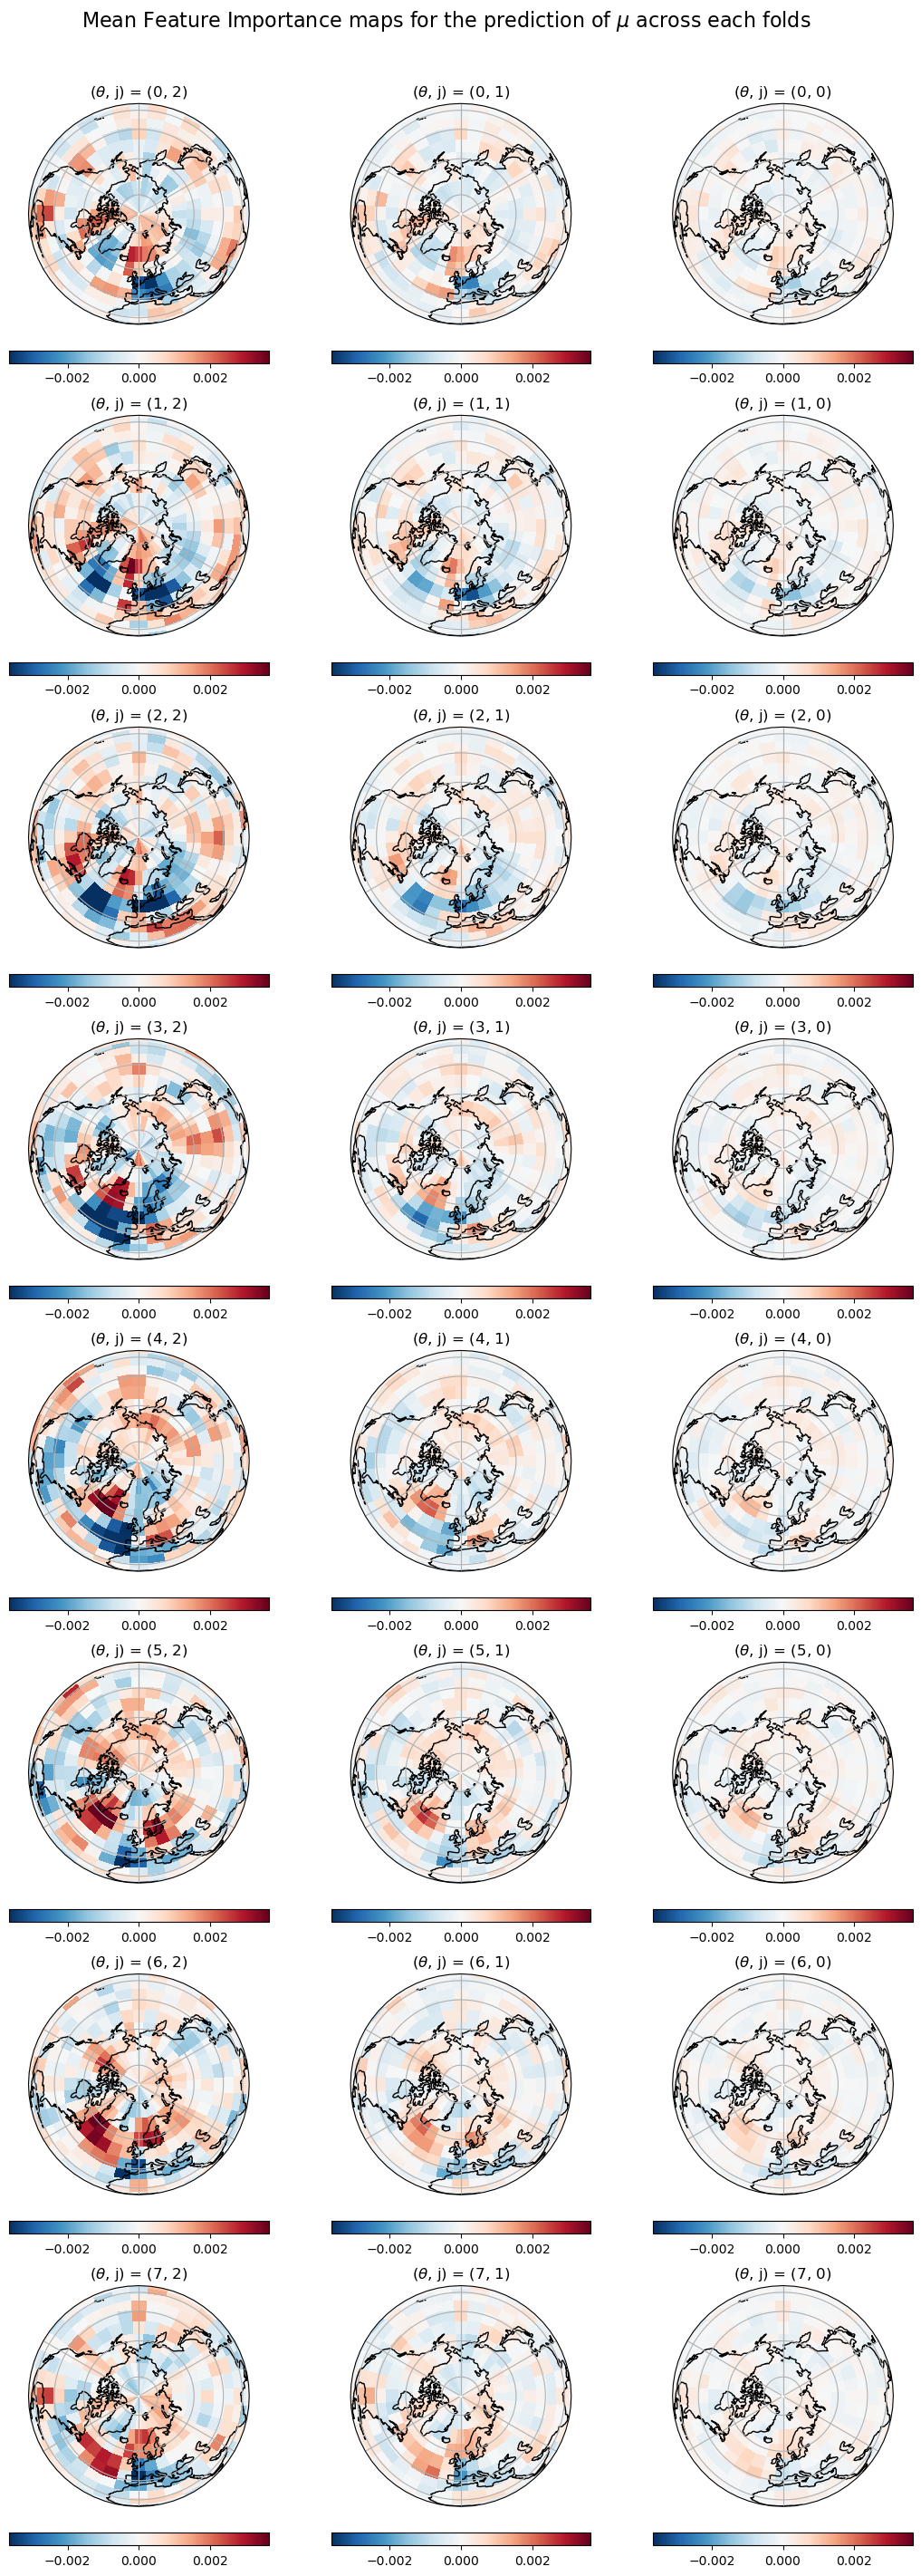

In [10]:
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

# plot a pannel with all importance maps for the 24 last channels
n_orient = 8
n_scale = 3
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(n_orient, n_scale, subplot_kw={'projection': projection}, figsize=(13, 35))

for thet in range(n_orient):
    for j in reversed(range(n_scale)):
        idx_channel = 1 + thet + j*n_orient
        # print(idx_channel)
        ax = axs[thet, 2-j]
        map_data = np.mean(fi_maps_wave[:,:,j, thet, :], axis=-1)
        img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
        scale = 0.00028
        # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
        mean_total_importance = np.mean(percentage_fi['total_imp'])
        img.set_clim(vmin=-scale*mean_total_importance , vmax=scale*mean_total_importance )
        # total_importance 
        # Add coastlines and gridlines
        ax.coastlines()
        ax.gridlines()
        # Add colorbar
        cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
        ax.set_title(fr'($\theta$, j) = ({thet}, {j})')
# suptitle with a pad of 20
plt.suptitle(r'Mean Feature Importance maps for the prediction of $\mu$ across each folds', fontsize=16, y=0.91)
plt.show()

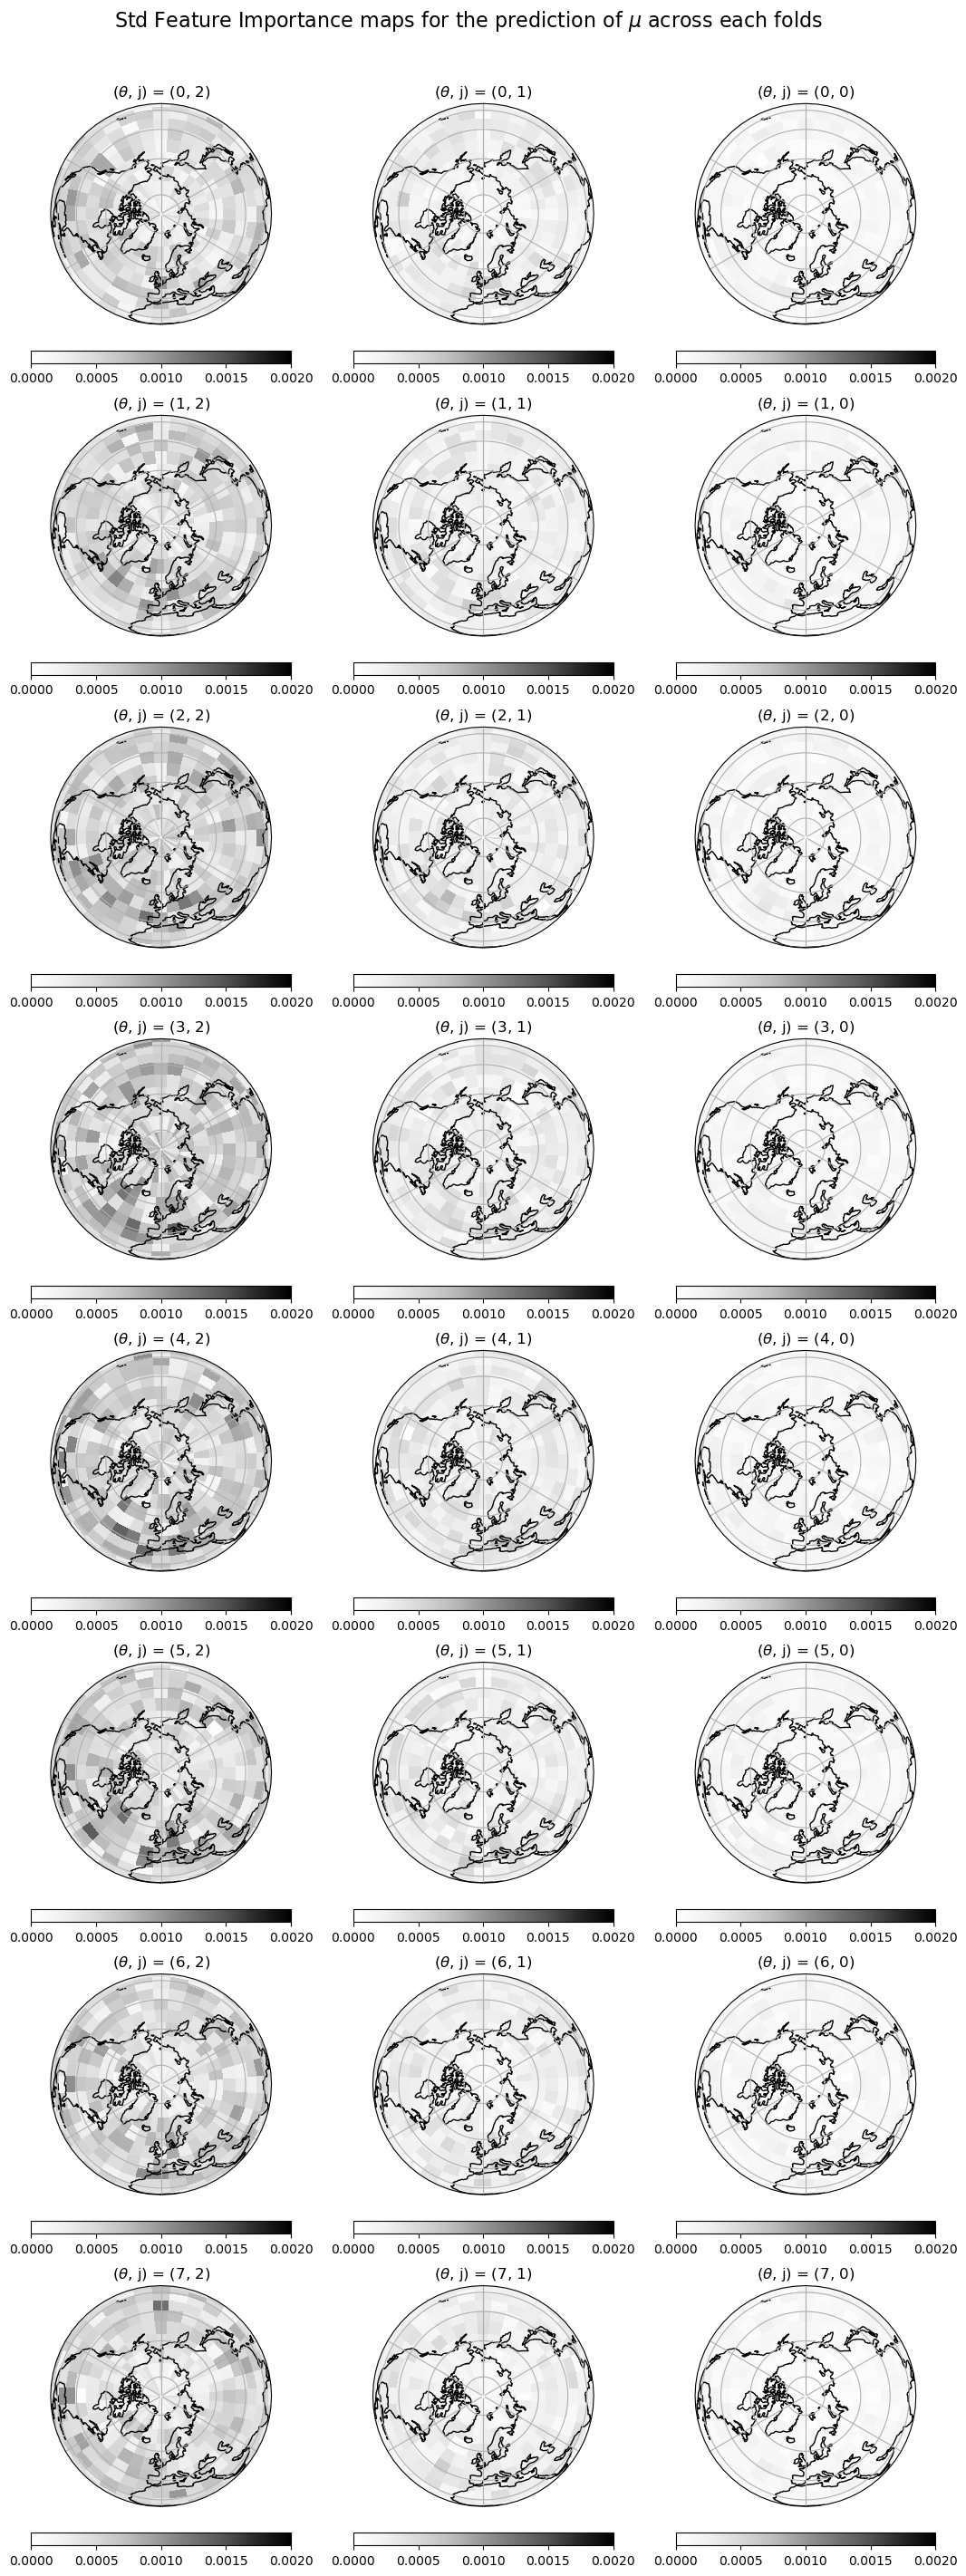

In [11]:
lat_coarse = lat[::2**3+1]
lon_coarse = lon[::2**3]

# plot a pannel with all importance maps for the 24 last channels
n_orient = 8
n_scale = 3
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(n_orient, n_scale, subplot_kw={'projection': projection}, figsize=(13, 35))

for thet in range(n_orient):
    for j in reversed(range(n_scale)):
        idx_channel = 1 + thet + j*n_orient
        # print(idx_channel)
        ax = axs[thet, 2-j]
        map_data = np.std(fi_maps_wave[:,:,j, thet, :], axis=-1)
        img = ax.pcolormesh(lon_coarse, lat_coarse, map_data, transform=ccrs.PlateCarree(), cmap='Greys')
        scale = 0.00028
        # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
        mean_total_importance = np.mean(percentage_fi['total_imp'])
        img.set_clim(vmin=0 , vmax=0.002)
        # total_importance 
        # Add coastlines and gridlines
        ax.coastlines()
        ax.gridlines()
        # Add colorbar
        cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
        ax.set_title(fr'($\theta$, j) = ({thet}, {j})')
# suptitle with a pad of 20
plt.suptitle(r'Std Feature Importance maps for the prediction of $\mu$ across each folds', fontsize=16, y=0.91)
plt.show()

# Reconstruct Z500 from Scattering transform coefficients

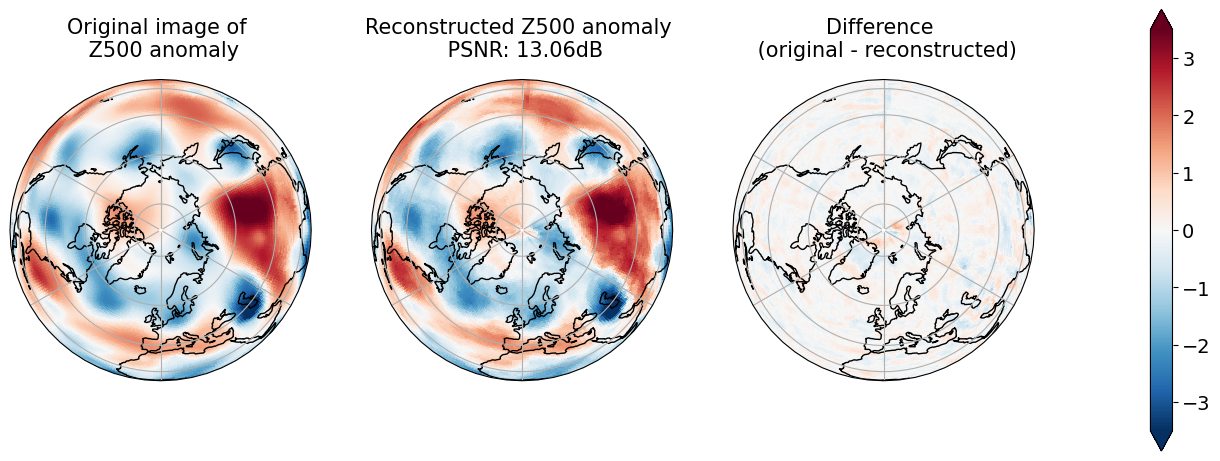

In [12]:
# Load data 
original_zg500 = np.load(os.getcwd() + '/Scatnet/original_zg500_map.npy')
reconstructed_zg500 = np.load(os.getcwd() + '/ScatNet/reconstructed_zg500_map.npy')
lat = np.load(os.getcwd() + '/common/lat.npy')
lon = np.load(os.getcwd() + '/common/lon.npy')


font_size_title = 15
font_tick = 14
plt.rcParams.update(plt.rcParamsDefault)
n_col= 2+1
projection = ccrs.Orthographic(central_latitude=90)
fig, axs = plt.subplots(1, n_col, subplot_kw={'projection': projection}, figsize=(15, 6))

ax = axs[0]
map_data = original_zg500
# Plot the map data using pcolormesh
# Replace 'map_data' with your actual map data
img = ax.pcolormesh(lon, lat, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# set the value 0 to white
img.set_clim(vmin=-3.5, vmax=3.5)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
# cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1, extend='both')
ax.set_title(f'Original image of \n Z500 anomaly', y=1.05, fontsize=font_size_title)

ax = axs[1]
map_data = reconstructed_zg500
# Plot the map data using pcolormesh
# Replace 'map_data' with your actual map data
img = ax.pcolormesh(lon, lat, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# set the value 0 to white
img.set_clim(vmin=-3.5, vmax=3.5)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
ax.set_title(f'Reconstructed Z500 anomaly \n PSNR: {13.06:.2f}dB', y=1.05, fontsize=font_size_title)

ax = axs[2]
# plot difference between original and reconstructed image
map_data = original_zg500 - reconstructed_zg500
# plot the map data using pcolormesh
img = ax.pcolormesh(lon, lat, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# set the value 0 to white
img.set_clim(vmin=-3.5, vmax=3.5)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
ax.set_title(f'Difference \n (original - reconstructed)', y=1.05, fontsize=font_size_title)

# Add colorbar
cbar = plt.colorbar(img, ax=axs, orientation='vertical', fraction=0.019, pad=0.1, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
plt.show()